In [1]:
import sys
sys.path.append('..')

In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)
torch.cuda.get_device_name(0)

cuda


'TITAN V'

In [12]:
skip_header = 0
example_path = '000001.png'
raw_example_data = cv2.imread(example_path, cv2.IMREAD_GRAYSCALE)
raw_example_data = np.transpose(raw_example_data)
fft_data = raw_example_data[:, skip_header:].astype(np.float32)[:, :, np.newaxis] / 255.
print(fft_data.shape)

(400, 576, 1)


In [13]:
angleResolutionInRad = 0.015708 # 0.9 deg
rangeResolutionsInMeter = 0.17361 # radiate-0.17361, robotcar-0.0432
cart_resolution = 0.25
cart_pixels = 501
cart_img = radar_polar_to_cartesian(angleResolutionInRad, fft_data, rangeResolutionsInMeter, cart_resolution, cart_pixels, True)

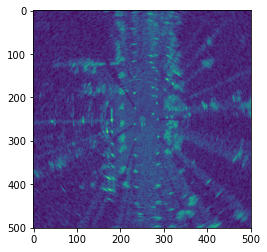

In [14]:
%matplotlib inline
plt.imshow(cart_img[0])

In [7]:
def radar_polar_to_cartesian(angleResolutionInRad: float, fft_data: np.ndarray, radar_resolution: float,
                             cart_resolution: float, cart_pixel_width: int, interpolate_crossover=True) -> np.ndarray:

    if (cart_pixel_width % 2) == 0:
        cart_min_range = (cart_pixel_width / 2 - 0.5) * cart_resolution
    else:
        cart_min_range = cart_pixel_width // 2 * cart_resolution
    coords = np.linspace(-cart_min_range, cart_min_range, cart_pixel_width, dtype=np.float32)
    Y, X = np.meshgrid(coords, -coords)
    sample_range = np.sqrt(Y * Y + X * X)
    sample_angle = np.arctan2(Y, X)
    sample_angle += (sample_angle < 0).astype(np.float32) * 2. * np.pi

    # Interpolate Radar Data Coordinates
    azimuth_step = angleResolutionInRad #azimuths[1] - azimuths[0]
    sample_u = (sample_range - radar_resolution / 2) / radar_resolution
    #sample_v = (sample_angle - azimuths[0]) / azimuth_step
    sample_v = (sample_angle - angleResolutionInRad) / azimuth_step

    # We clip the sample points to the minimum sensor reading range so that we
    # do not have undefined results in the centre of the image. In practice
    # this region is simply undefined.
    sample_u[sample_u < 0] = 0

    if interpolate_crossover:
        fft_data = np.concatenate((fft_data[-1:], fft_data, fft_data[:1]), 0)
        sample_v = sample_v + 1

    polar_to_cart_warp = np.stack((sample_u, sample_v), -1)
    cart_img = np.expand_dims(cv2.remap(fft_data, polar_to_cart_warp, None, cv2.INTER_LINEAR), 0)
    return cart_img